# Spike-based Brain-Machine Interface (BMI) Decoding
This tutorial will walk you trough step-by-step BMI decoding.
Dataset [Sabes Lab](https://zenodo.org/record/3854034)
### Download the dataset

In [37]:
# import packages
import os
import requests
import numpy as np
import h5py
from bmi.utils import customize_plot, legend_plot
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
# URL of recording data to download
URL_PATH = 'https://zenodo.org/record/3854034/files/indy_20160407_02.mat'  
# directory to store the downloaded data
raw_dirname = os.path.join('data', 'raw')
# create folder if it doesn't exist
os.makedirs(raw_dirname, exist_ok=True)
# specify filename to store downloaded data
raw_filename = URL_PATH.split('/')[-1]
raw_filepath = os.path.join(raw_dirname, raw_filename)
# make http request to get data from URL
#data = requests.get(URL_PATH)
# store data to local file path
#with open(raw_filepath, 'wb')as f:
#    f.write(data.content)
print(f"Finished downloading and storing data into file: {raw_filepath}!")


Finished downloading and storing data into file: data\raw\indy_20160407_02.mat!


### Get and store spike and kinematic data

In [3]:
# directory to store the processed (spike and kinematic) data
processed_dirname = os.path.join('data', 'processed')
# create folder if it doesn't exist
os.makedirs(processed_dirname, exist_ok=True)
# specify filename to store the processed data
processed_filename = raw_filename.split('.')[0]+'.h5'
processed_filepath = os.path.join(processed_dirname, processed_filename)
# process and store the raw data
#run = f"python process_data.py --input_filepath {raw_filepath} --output_filepath {processed_filepath}"    
#!{run}


### Create dataset for training and testing BMI decoder

In [6]:
# directory to store the dataset
dataset_dirname = os.path.join('data', 'dataset')
# create folder if it doesn't exist
os.makedirs(dataset_dirname, exist_ok=True)

methods = ['binning', 'gaussian', 'baks']
for method in methods:
    dataset_filename = f"{raw_filename.split('.')[0]}_{method}.h5"
    dataset_filepath = os.path.join(dataset_dirname, dataset_filename)
    #run = f"python make_dataset.py --input_filepath {processed_filepath} --output_filepath {dataset_filepath} --method {method}"
    #!{run}
    

### Evaluate the performance of BMI decoder
We use time-series cross-validation 

<div align="center">
  <img src="figures/cross_validation.PNG"/>
</div>

![](figures/cross_validation.PNG)

Performance metrics:
1. Root mean squared error (RMSE)
$$ \text{RMSE} = \sqrt{\textstyle\sum_{i=1}^{N}(\hat{y}_i - y_i)^2/N} $$
2. Pearson's correlation coefficient (CC)
$$ \text{CC} = \frac{\sum_{t=1}^{N}(y_t-\bar{y})(\hat{y}_t-\bar{\hat{y}}_t)}{\sqrt{\sum_{t=1}^{N}(y_t-\bar{y})^2}\sqrt{\sum_{t=1}^{N}(\hat{y}_t-\bar{\hat{y}}_t)^2}} $$


### Train and evaluate classical BMI decoders
1. Kalman filter (KF)
2. Wiener filter (WF)

In [8]:
# directory to store the result
result_dirname = os.path.join('results', 'tap')
# create folder if it doesn't exist
os.makedirs(result_dirname, exist_ok=True)
method = 'baks'
decoder = 'wf'
timesteps = np.arange(1,11)
dataset_filename = f"{raw_filename.split('.')[0]}_{method}.h5"
dataset_filepath = os.path.join(dataset_dirname, dataset_filename)
for tap in timesteps:
    result_filename = f"{raw_filename.split('.')[0]}_{method}_{decoder}_tap{tap}.h5"
    result_filepath = os.path.join(result_dirname, result_filename)
    run = f"python opt_wf_decoder.py --input_filepath {dataset_filepath} --output_filepath {result_filepath} --timesteps {tap}"
    !{run}

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'reg_type': '', 'reg_alpha': 0, 'timesteps': 1}
Fold-1 | RMSE valid = 36.29, CC valid = 0.72
Fold-2 | RMSE valid = 39.52, CC valid = 0.74
Fold-3 | RMSE valid = 37.67, CC valid = 0.76
Fold-4 | RMSE valid = 38.04, CC valid = 0.72
Fold-5 | RMSE valid = 34.31, CC valid = 0.75
Storing results into file: results\tap\indy_20160407_02_baks_wf_tap1.h5
Whole processes took 0.00 minutes
Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'reg_type': '', 'reg_alpha': 0, 'timesteps': 2}
Fold-1 | RMSE valid = 36.22, CC valid = 0.72
Fold-2 | RMSE valid = 38.25, CC valid = 0.76
Fold-3 | RMSE valid = 36.37, CC valid = 0.78
Fold-4 | RMSE valid = 36.70, CC valid = 0.75
Fold-5 | RMSE valid = 32.91, CC valid = 0.78
Storing results into file: results\tap\indy_20160407_02_baks_wf_tap2.h5
Whole processes took 0.01 minutes
Reading dataset from file: data\dataset\indy_20160

Plot the number of taps vs decoding performance

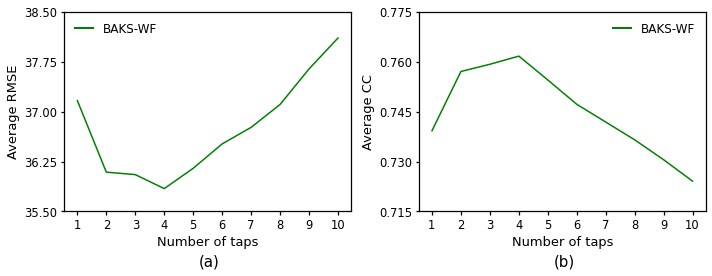

Storing figure to filename: figures\indy_20160407_02_baks_wf_tap.png
Best number of taps: 4 with RMSE: 35.84
Best number of taps: 4 with CC: 0.76


In [36]:
# directory to store the result
result_dirname = os.path.join('results', 'tap')
method = 'baks'
decoder = 'wf'
rmse_tap = []
cc_tap = []
for tap in timesteps:
    # reading results
    result_filename = f"{raw_filename.split('.')[0]}_{method}_{decoder}_tap{tap}.h5"
    result_filepath = os.path.join(result_dirname, result_filename)
    with h5py.File(result_filepath, 'r') as f:
        rmse_valid = f['rmse_valid_folds'][()]
        cc_valid = f['cc_valid_folds'][()]
    rmse_tap.append(rmse_valid[:,np.newaxis])
    cc_tap.append(cc_valid[:,np.newaxis])
rmse_tap = np.concatenate(rmse_tap, axis=1)
cc_tap = np.concatenate(cc_tap, axis=1)
# calculate the mean across folds
rmse_mean = np.mean(rmse_tap, axis=0)
cc_mean = np.mean(cc_tap, axis=0)
# find the index of tap with the best performance
rmse_idx = np.argmin(rmse_mean)
rmse_val = np.min(rmse_mean)
cc_idx = np.argmax(cc_mean)
cc_val = np.max(cc_mean)

label = f"{method}-{decoder}".upper()

# plot the result
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(timesteps, rmse_mean, color='g', linestyle='-', linewidth=1.5, label=label)
customize_plot(ax[0], xlabel='Number of taps', ylabel='Average RMSE', fontsize=13, xticks=timesteps, xticklabels=timesteps, xlim=None, ylim=[35.5, 38.5], rotation=0)
legend_plot(ax[0], loc='upper left')

ax[1].plot(timesteps, cc_mean, color='g', linestyle='-', linewidth=1.5, label=label)
customize_plot(ax[1], xlabel='Number of taps', ylabel='Average CC', fontsize=13, xticks=timesteps, xticklabels=timesteps, xlim=None, ylim=[0.715, 0.775], rotation=0)
legend_plot(ax[1], loc='upper right')
# add subfigure/panel label
ax_label = ['(a)', '(b)']
xy_coord = [(0.47, -0.25), (0.47, -0.25)]
for i in range(len(ax_label)):
    ax[i].text(xy_coord[i][0], xy_coord[i][1], ax_label[i], transform=ax[i].transAxes, fontsize=15, va='center')

plt.tight_layout()
plt.show()

# directory to store figure
figure_dirname = 'figures'
# create folder if it doesn't exist
os.makedirs(figure_dirname, exist_ok=True)
figure_filename = f"{raw_filename.split('.')[0]}_{method}_{decoder}_tap.png"
figure_filepath = os.path.join(figure_dirname, figure_filename)
print (f"Storing figure to filename: {figure_filepath}")
fig.savefig(figure_filepath, bbox_inches='tight')

print(f"Best number of taps: {timesteps[rmse_idx]} with RMSE: {rmse_val:.2f}")
print(f"Best number of taps: {timesteps[cc_idx]} with CC: {cc_val:.2f}")



Train WF decoder using number of taps (i.e. timesteps) = 4.

In [22]:
# directory to store the result
result_dirname = os.path.join('results', 'decoder')
# create folder if it doesn't exist
os.makedirs(result_dirname, exist_ok=True)
method = 'baks'
decoder = 'wf'
tap = 4
dataset_filename = f"{raw_filename.split('.')[0]}_{method}.h5"
dataset_filepath = os.path.join(dataset_dirname, dataset_filename)
result_filename = f"{raw_filename.split('.')[0]}_{method}_{decoder}.h5"
result_filepath = os.path.join(result_dirname, result_filename)
run = f"python eval_wf_decoder.py --input_filepath {dataset_filepath} --output_filepath {result_filepath} --timesteps {tap}"
!{run}

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'reg_type': '', 'reg_alpha': 0, 'timesteps': 4}
Fold-1 | RMSE test = 36.97, CC test = 0.75
Fold-2 | RMSE test = 35.28, CC test = 0.77
Fold-3 | RMSE test = 35.68, CC test = 0.75
Fold-4 | RMSE test = 33.85, CC test = 0.79
Fold-5 | RMSE test = 43.08, CC test = 0.67
Storing results into file: results\decoder\indy_20160407_02_baks_wf.h5
Whole processes took 0.01 minutes


Train and evaluate KF decoder

In [25]:
# directory to store the result
result_dirname = os.path.join('results', 'decoder')
# create folder if it doesn't exist
os.makedirs(result_dirname, exist_ok=True)
method = 'baks'
decoder = 'kf'
dataset_filename = f"{raw_filename.split('.')[0]}_{method}.h5"
dataset_filepath = os.path.join(dataset_dirname, dataset_filename)
result_filename = f"{raw_filename.split('.')[0]}_{method}_{decoder}.h5"
result_filepath = os.path.join(result_dirname, result_filename)
run = f"python eval_kf_decoder.py --input_filepath {dataset_filepath} --output_filepath {result_filepath}"
!{run}

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'reg_type': '', 'reg_alpha': 0}
Fold-1 | RMSE test = 36.20, CC test = 0.76
Fold-2 | RMSE test = 34.44, CC test = 0.78
Fold-3 | RMSE test = 35.76, CC test = 0.76
Fold-4 | RMSE test = 33.78, CC test = 0.79
Fold-5 | RMSE test = 43.23, CC test = 0.67
Storing results into file: results\decoder\indy_20160407_02_baks_kf.h5
Whole processes took 0.10 minutes


### Optimize hyperparameters for deep learning-based BMI decoders

In [46]:
# directory to store the result
result_dirname = 'params'
# create folder if it doesn't exist
os.makedirs(result_dirname, exist_ok=True)
feature = 'mua'
method = 'baks'
decoders = ['mlp', 'lstm', 'qrnn']
n_trials = 2  # Number of trials for optimization
timeout = 300 # Stop study after the given number of seconds
n_startup_trials = 1 # Number of trials in the beginning for which pruning is disabled
for decoder in decoders:
    result_filename = f"{raw_filename.split('.')[0]}_{feature}_{method}_{decoder}.pkl"
    result_filepath = os.path.join(result_dirname, result_filename)
    run = f"python opt_dl_decoder.py --input_filepath {dataset_filepath} --output_filepath {result_filepath} --decoder {decoder} --n_trials {n_trials} --timeout {timeout} --n_startup_trials {n_startup_trials}"
    !{run}

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'input_dim': 90, 'output_dim': 2, 'timesteps': 1, 'n_layers': 1, 'units': 250, 'window_size': 2, 'batch_size': 32, 'epochs': 100, 'learning_rate': 0.04448285937712399, 'dropout': 0.2, 'optimizer': 'RMSProp', 'loss': 'mse', 'metric': 'mse'}
Compiling and training a model
Training stopped at epoch 8 with the best epoch at 3
Training the model took 0.02 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 9 with the best epoch at 4
Training the model took 0.02 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 14 with the best epoch at 9
Training the model took 0.03 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 13 with the best epoch at 8
Training the model took 0.03 minutes
Evaluating the model performance
Compiling and training a model
Training stoppe

[I 2022-01-23 15:05:05,593] A new study created in memory with name: no-name-0079589b-f3b8-45ef-b546-08412cf237ee
2022-01-23 15:05:05.607954: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: User

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration: {'input_dim': 90, 'output_dim': 2, 'timesteps': 4, 'n_layers': 1, 'units': 150, 'window_size': 2, 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.050198949081335674, 'dropout': 0.2, 'optimizer': 'Adam', 'loss': 'mse', 'metric': 'mse'}
Compiling and training a model
Training stopped at epoch 12 with the best epoch at 7
Training the model took 0.09 minutes


[I 2022-01-23 15:05:20,487] A new study created in memory with name: no-name-0a86babd-d45c-4faa-8ad5-d171c1eca60f
2022-01-23 15:05:20.512123: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: User

Evaluating the model performance
Compiling and training a model
Training stopped at epoch 16 with the best epoch at 11
Training the model took 0.12 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 8 with the best epoch at 3
Training the model took 0.08 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 8 with the best epoch at 3
Training the model took 0.10 minutes
Evaluating the model performance
Compiling and training a model
Training stopped at epoch 10 with the best epoch at 5
Training the model took 0.14 minutes
Evaluating the model performance
Hyperparameter configuration: {'input_dim': 90, 'output_dim': 2, 'timesteps': 2, 'n_layers': 1, 'units': 100, 'window_size': 2, 'batch_size': 64, 'epochs': 100, 'learning_rate': 0.06932944285870404, 'dropout': 0.2, 'optimizer': 'RMSProp', 'loss': 'mse', 'metric': 'mse'}
Compiling and training a model
Training stopped at epoch 12 with the best epo

[I 2022-01-23 15:06:23,709] A new study created in memory with name: no-name-91485199-c3f9-46b5-989c-54792dd217e5
2022-01-23 15:06:23.732070: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
C:\anaconda\lib\site-packages\optuna\trial\_trial.py:590: UserWarning: The reported 

### Train and evaluate deep learning-based BMI decoders

In [47]:
# directory to store the result
result_dirname = os.path.join('results', 'decoder')
feature = 'mua'
method = 'baks'
decoders = ['mlp', 'lstm', 'qrnn']
for decoder in decoders:
    result_filename = f"{raw_filename.split('.')[0]}_{feature}_{method}_{decoder}.h5"
    result_filepath = os.path.join(result_dirname, result_filename)
    config_filename = f"{raw_filename.split('.')[0]}_{feature}_{method}_{decoder}_opt.json"
    config_filepath = os.path.join('params', config_filename)
    run = f"python eval_dl_decoder.py --input_filepath {dataset_filepath} --output_filepath {result_filepath} --decoder {decoder} --config_filepath {config_filepath}"
    !{run}

Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration setting
Using hyperparameter configuration from a file: params\indy_20160407_02_mua_baks_mlp_opt.json
Hyperparameter configuration: {'timesteps': 1, 'n_layers': 2, 'units': 350, 'batch_size': 64, 'learning_rate': 0.0035, 'dropout': 0.3, 'optimizer': 'RMSProp', 'epochs': 6, 'input_dim': 90, 'output_dim': 2, 'window_size': 2, 'loss': 'mse', 'metric': 'mse'}
Compiling and training a model
Total params: 155402
Trainable params: 155402
Non-trainable params: 0
Training the model took 0.03 minutes
Evaluating the model performance
Compiling and training a model
Total params: 155402
Trainable params: 155402
Non-trainable params: 0
Training the model took 0.03 minutes
Evaluating the model performance

2022-01-23 15:16:00.507660: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Compiling and training a model
Total params: 155402
Trainable params: 155402
Non-trainable params: 0
Training the model took 0.04 minutes
Evaluating the model performance
Compiling and training a model
Total params: 155402
Trainable params: 155402
Non-trainable params: 0
Training the model took 0.04 minutes
Evaluating the model performance
Compiling and training a model
Total params: 155402
Trainable params: 155402
Non-trainable params: 0
Training the model took 0.04 minutes
Evaluating the model performance
Fold-1 | RMSE test = 33.92, CC test = 0.80
Fold-2 | RMSE test = 31.53, CC test = 0.82
Fold-3 | RMSE test = 34.09, CC test = 0.79
Fold-4 | RMSE test = 30.60, CC test = 0.82
Fold-5 | RMSE test = 35.98, CC test = 0.77
Storing results into file: results\decoder\indy_20160407_02_mua_baks_mlp.h5
Whole processes took 0.18 minutes
Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration setting
Using hyperparameter configuration from a file: params\indy

2022-01-23 15:16:15.375504: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Reading dataset from file: data\dataset\indy_20160407_02_baks.h5
Hyperparameter configuration setting
Using hyperparameter configuration from a file: params\indy_20160407_02_mua_baks_qrnn_opt.json
Hyperparameter configuration: {'timesteps': 5, 'n_layers': 1, 'units': 600, 'batch_size': 96, 'learning_rate': 0.0072, 'dropout': 0.5, 'optimizer': 'RMSProp', 'epochs': 14, 'input_dim': 90, 'output_dim': 2, 'window_size': 2, 'loss': 'mse', 'metric': 'mse'}
Compiling and training a model
Total params: 327002
Trainable params: 327002
Non-trainable params: 0
Training the model took 0.25 minutes
Evaluating the model performance
Compiling and training a model
Total params: 327002
Trainable params: 327002
Non-trainable params: 0
Training the model took 0.30 minutes
Evaluating the model performance
Compiling and training a model
Total params: 327002
Trainable params: 327002
Non-trainable params: 0
Training the model took 0.32 minutes

2022-01-23 15:17:31.376939: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert



Evaluating the model performance
Compiling and training a model
Total params: 327002
Trainable params: 327002
Non-trainable params: 0
Training the model took 0.37 minutes
Evaluating the model performance
Compiling and training a model
Total params: 327002
Trainable params: 327002
Non-trainable params: 0
Training the model took 0.41 minutes
Evaluating the model performance
Fold-1 | RMSE test = 32.13, CC test = 0.82
Fold-2 | RMSE test = 29.99, CC test = 0.84
Fold-3 | RMSE test = 29.05, CC test = 0.84
Fold-4 | RMSE test = 30.16, CC test = 0.83
Fold-5 | RMSE test = 36.82, CC test = 0.76
Storing results into file: results\decoder\indy_20160407_02_mua_baks_qrnn.h5
Whole processes took 1.67 minutes


### Plot the result comparison

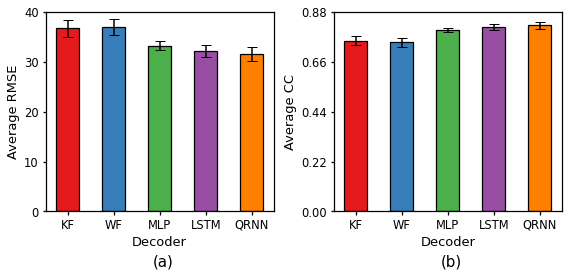

Storing figure to filename: figures\indy_20160407_02_mua_baks_decoder.png
Best decoder: QRNN with RMSE: 31.63
Best decoder: QRNN with CC: 0.82


In [48]:
# directory to store the result
result_dirname = os.path.join('results', 'decoder')
feature = 'mua'
method = 'baks'
decoders = ['kf', 'wf', 'mlp', 'lstm', 'qrnn']
rmse_decoder = []
cc_decoder = []
for decoder in decoders:
    # reading results
    result_filename = f"{raw_filename.split('.')[0]}_{feature}_{method}_{decoder}.h5"
    result_filepath = os.path.join(result_dirname, result_filename)
    with h5py.File(result_filepath, 'r') as f:
        rmse_test = f['rmse_test_folds'][()]
        cc_test = f['cc_test_folds'][()]
    rmse_decoder.append(rmse_test[:,np.newaxis])
    cc_decoder.append(cc_test[:,np.newaxis])
rmse_decoder = np.concatenate(rmse_decoder, axis=1)
cc_decoder = np.concatenate(cc_decoder, axis=1)
# calculate the mean across folds
rmse_mean = np.mean(rmse_decoder, axis=0)
rmse_error = stats.sem(rmse_decoder, axis=0)
cc_mean = np.mean(cc_decoder, axis=0)
cc_error = stats.sem(cc_decoder, axis=0)
# find the index of tap with the best performance
rmse_idx = np.argmin(rmse_mean)
rmse_val = np.min(rmse_mean)
cc_idx = np.argmax(cc_mean)
cc_val = np.max(cc_mean)

labels = [decoder.upper() for decoder in decoders]
cmap_name = 'Set1'
cmap = cm.get_cmap(cmap_name)
colors = cmap.colors[:len(decoders)]

# plot the result
fig, ax = plt.subplots(1, 2, figsize=(8,4))
width = 0.5
xbar = [x + width for x in range(len(decoders))]
for i in range(len(decoders)):  
    ax[0].bar(xbar[i], rmse_mean[i], yerr=rmse_error[i], width=width, linewidth=1.25, capsize=5, color=colors[i], edgecolor='k')
    customize_plot(ax[0], xlabel='Decoder', ylabel='Average RMSE', fontsize=13, xticks=xbar, xticklabels=labels, xlim=None, ylim=[0, 40], rotation=0)

for i in range(len(decoders)):  
    ax[1].bar(xbar[i], cc_mean[i], yerr=cc_error[i], width=width, linewidth=1.25, capsize=5, color=colors[i], edgecolor='k')
    customize_plot(ax[1], xlabel='Decoder', ylabel='Average CC', fontsize=13, xticks=xbar, xticklabels=labels, xlim=None, ylim=[0, 0.88], rotation=0)
# add subfigure/panel label
ax_label = ['(a)', '(b)']
xy_coord = [(0.47, -0.25), (0.47, -0.25)]
for i in range(len(ax_label)):
    ax[i].text(xy_coord[i][0], xy_coord[i][1], ax_label[i], transform=ax[i].transAxes, fontsize=15, va='center')

plt.tight_layout()
plt.show()

figure_filename = f"{raw_filename.split('.')[0]}_{feature}_{method}_decoder.png"
figure_filepath = os.path.join(figure_dirname, figure_filename)
print (f"Storing figure to filename: {figure_filepath}")
fig.savefig(figure_filepath, bbox_inches='tight')

print(f"Best decoder: {labels[rmse_idx]} with RMSE: {rmse_val:.2f}")
print(f"Best decoder: {labels[cc_idx]} with CC: {cc_val:.2f}")